In [1]:
import pandas as pd

df = pd.read_pickle('full_dataset.pkl')

df.head()

,acidic_rev,bitter_rev,sweet_rev,umami_rev,spicy_rev,name,minutes,contributor_id,submitted,tags,...,44229138,46779070,53425122,53472027,54670067,57357963,57370186,57501028,92043681,118855872
recipe_id,,,,,,,,,,,,,,,,,,,,,
38,0,0,0,0,0,low fat berry blue frozen dessertlow fat berry...,5940.0,6132.0,1999-08-091999-08-091999-08-091999-08-09,"['weeknight', 'time-to-make', 'course', 'prepa...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0,0,0,0,0,biryanibiryanibiryanibiryanibiryanibiryanibiry...,6890.0,40742.0,1999-08-291999-08-291999-08-291999-08-291999-0...,"['weeknight', 'time-to-make', 'course', 'main-...",...,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0
40,0,0,0,0,2,best lemonadebest lemonadebest lemonadebest le...,210.0,9396.0,1999-09-051999-09-051999-09-051999-09-051999-0...,"['60-minutes-or-less', 'time-to-make', 'course...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0,0,0,0,0,carina s tofu vegetable kebabscarina s tofu ve...,21900.0,23790.0,1999-09-031999-09-031999-09-031999-09-031999-0...,"['weeknight', 'time-to-make', 'course', 'main-...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0,0,0,0,0,best blackbottom piebest blackbottom piebest b...,2100.0,523185.0,1999-08-211999-08-211999-08-211999-08-211999-0...,"['weeknight', 'time-to-make', 'course', 'cuisi...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [11]:
df.columns[:15]

Index(['acidic_rev', 'bitter_rev', 'sweet_rev', 'umami_rev', 'spicy_rev',
       'name', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition',
       'n_steps', 'steps', 'description', 'n_ingredients'],
      dtype='object')

In [2]:
df_train=df[df.columns[df.columns.isin(['name','minutes','contributor_id','submitted','tags','nutrition','n_steps','steps','description','n_ingredients'])==False]].copy()

df_train[['acidic_rev','bitter_rev','sweet_rev','umami_rev','spicy_rev']]=df_train[['acidic_rev','bitter_rev','sweet_rev','umami_rev','spicy_rev']].astype(bool)

df_train_filt=df_train[df_train[['acidic_rev','bitter_rev','sweet_rev','umami_rev','spicy_rev']].sum(axis=1)>0].fillna(0)

In [3]:
from sklearn.model_selection import train_test_split

# Assuming df_train is your dataset and it's already loaded

# Separating features and targets
X = df_train_filt.drop(['acidic_rev', 'bitter_rev', 'sweet_rev', 'umami_rev', 'spicy_rev'], axis=1)
y = df_train_filt[['acidic_rev', 'bitter_rev', 'sweet_rev', 'umami_rev', 'spicy_rev']]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize the base classifier
base_rf = RandomForestClassifier(n_estimators=2, random_state=42)

# Create the MultiOutputClassifier
multi_target_rf = MultiOutputClassifier(base_rf, n_jobs=-1)

# Train the model
multi_target_rf.fit(X_train, y_train)


from sklearn.metrics import accuracy_score, hamming_loss

# Predict on the test set
y_pred = multi_target_rf.predict(X_test)

# Calculate metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Hamming Loss:", hamming_loss(y_test, y_pred))

Accuracy: 0.17636916002955907
Hamming Loss: 0.2827161507512932


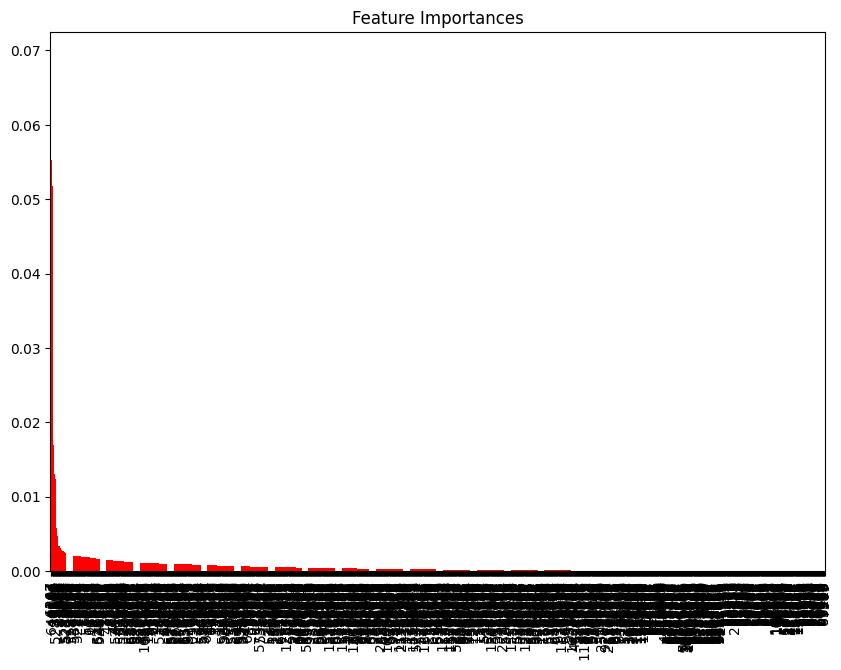

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming base_rf is your trained RandomForestClassifier within MultiOutputClassifier
feature_importances = np.mean([
    tree.feature_importances_ for tree in multi_target_rf.estimators_[0].estimators_
], axis=0)

# Get the indices of the features sorted by importance
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 7))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[sorted_idx],
        color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

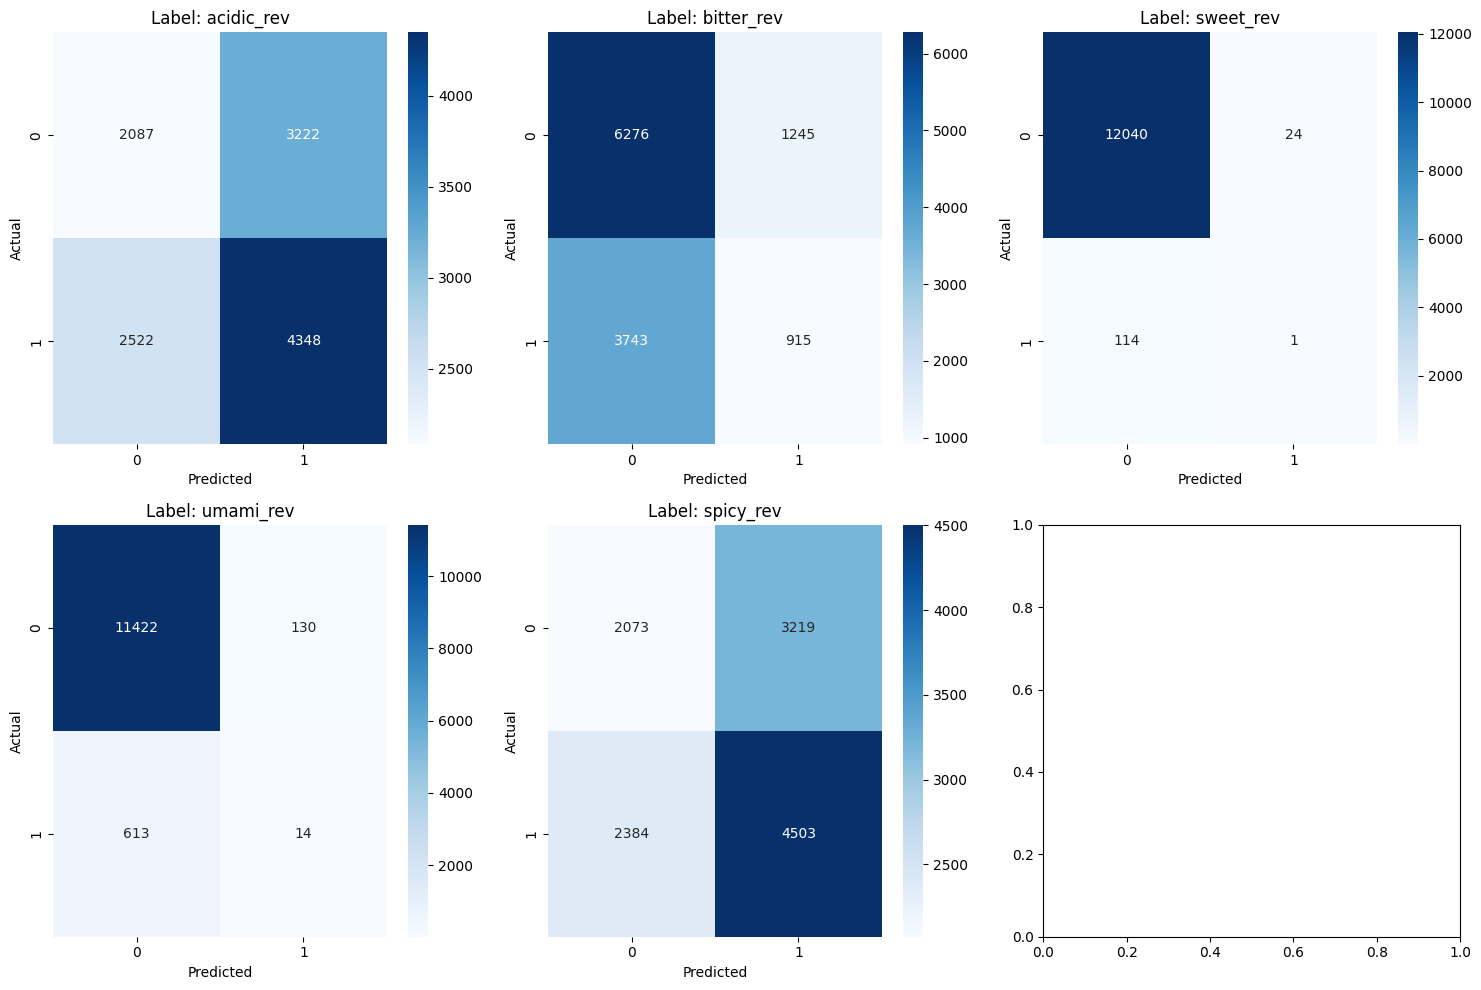

In [5]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Compute confusion matrix for each label
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, (label, cm) in enumerate(zip(y.columns, conf_matrices)):
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i//3, i%3], cmap="Blues")
    axes[i//3, i%3].set_title(f'Label: {label}')
    axes[i//3, i%3].set_ylabel('Actual')
    axes[i//3, i%3].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Determine the number of input features
n_features = X_train.shape[1]
# Determine the number of output labels
n_labels = y_train.shape[1]

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(n_features,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_labels, activation='sigmoid')  # Use sigmoid for multi-label classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary crossentropy for multi-label classification
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')

# Predict on the test set (optional)
y_pred = model.predict(X_test)




Epoch 1/20


1218/1218 [==============================] - 3s 2ms/step - loss: 0.4840 - accuracy: 0.4690 - val_loss: 0.4592 - val_accuracy: 0.5652
Epoch 2/20
1218/1218 [==============================] - 2s 2ms/step - loss: 0.4608 - accuracy: 0.5005 - val_loss: 0.4587 - val_accuracy: 0.5393
Epoch 3/20
1218/1218 [==============================] - 3s 2ms/step - loss: 0.4600 - accuracy: 0.4981 - val_loss: 0.4584 - val_accuracy: 0.4370
Epoch 4/20
1218/1218 [==============================] - 2s 2ms/step - loss: 0.4596 - accuracy: 0.4972 - val_loss: 0.4589 - val_accuracy: 0.5351
Epoch 5/20
1218/1218 [==============================] - 2s 2ms/step - loss: 0.4594 - accuracy: 0.5143 - val_loss: 0.4587 - val_accuracy: 0.5590
Epoch 6/20
1218/1218 [==============================] - 2s 2ms/step - loss: 0.4592 - accuracy: 0.5093 - val_loss: 0.4585 - val_accuracy: 0.4258
Epoch 7/20
1218/1218 [==============================] - 2s 2ms/step - loss: 0.4589 - accuracy: 0.5135 - val_loss: 0.4584 - val_accu

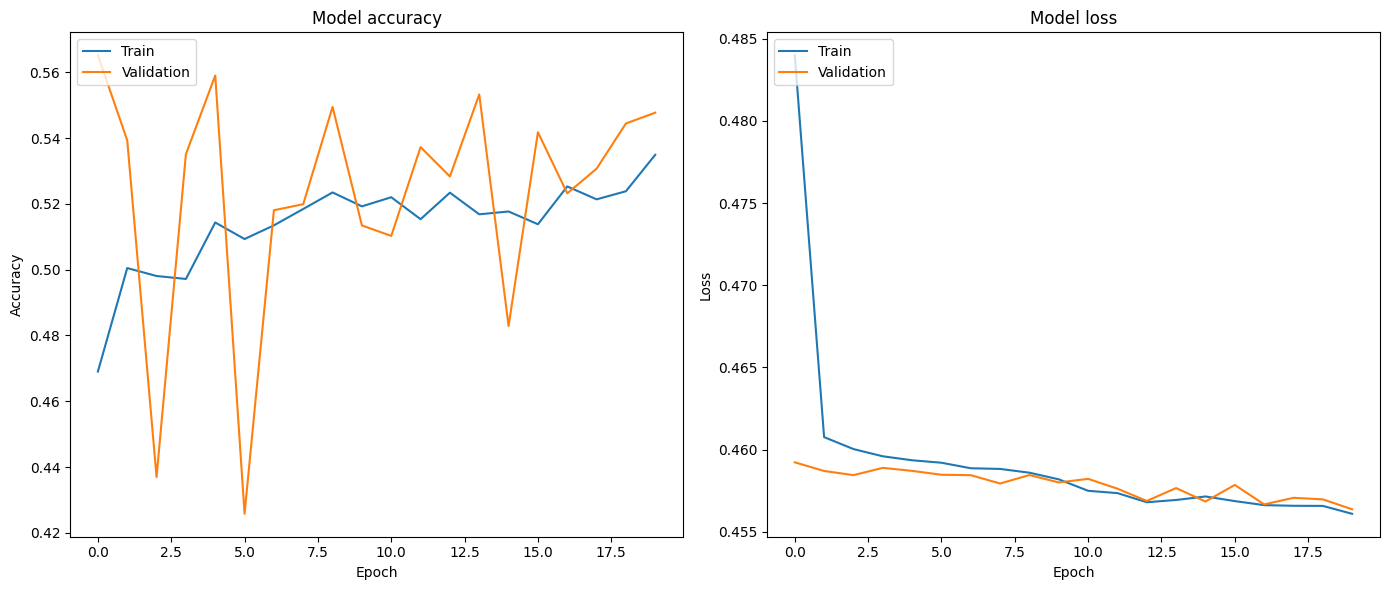

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

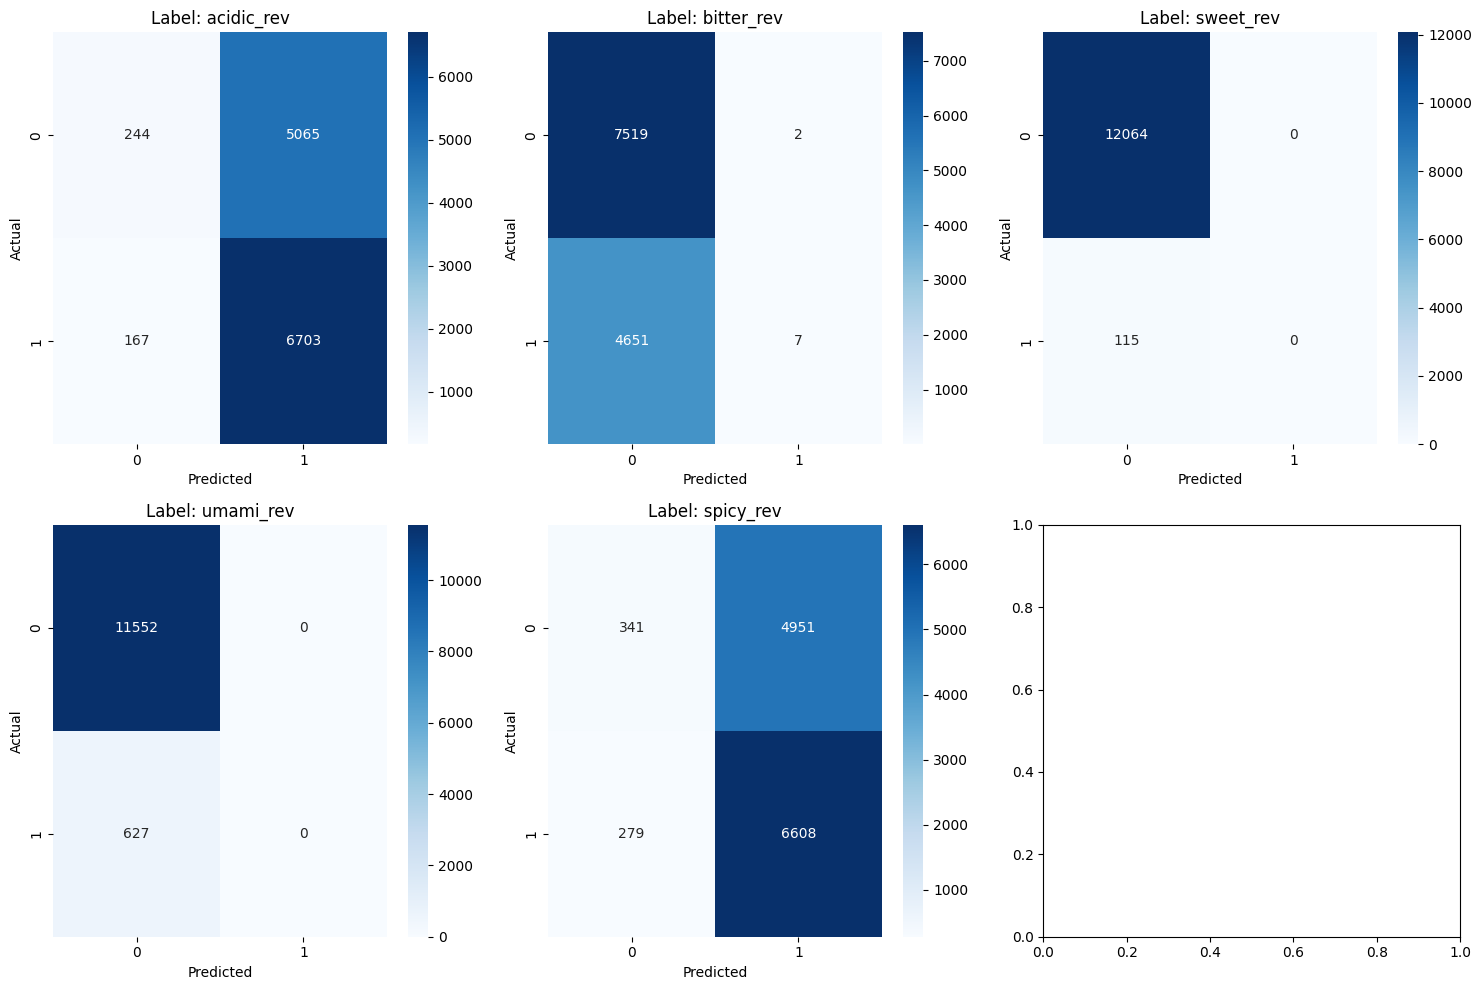

In [8]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Assuming y_pred is already thresholded to binary values if necessary
conf_matrices = multilabel_confusion_matrix(y_test, (y_pred > 0.5).astype(int))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, (label, cm) in enumerate(zip(y.columns, conf_matrices)):
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[i//3, i%3], cmap="Blues")
    axes[i//3, i%3].set_title(f'Label: {label}')
    axes[i//3, i%3].set_ylabel('Actual')
    axes[i//3, i%3].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

---------